Matthew Jockers has been using sentence-level sentiment as a proxy to plot arcs.

In Jockers' experience, word-based sentiment has been fairly robust in comparison to more contextual sentence parsing, meaning the bag-of-words provided by the Extracted Features dataset may still be rated for sentiment. The HTRC Extracted Features dataset doesn't go down to the granularity of a sentence, so we'll apply the approach at the page-level. Given that sentence-sentiment assignments will have to be smoothed to account for localized noise, this should still be comparable.

http://www.matthewjockers.net/2015/02/02/syuzhet/

In [ ]:
%matplotlib inline
from htrc_features import FeatureReader, utils
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

AFINN-111 will be used for sentiment assignments, an iteration on [Nielsen 2011](#References). To import the data, download the [zip file](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010) and unpack `AFINN-111.txt`.

In [ ]:
afinn = pd.read_csv("AFINN-111.txt", sep='\t', names=['token','valence'])
afinn[::600]

,token,valence
0,abandon,-2
600,delay,-1
1200,hooliganism,-2
1800,proudly,2
2400,warm,1


We'll use Portrait of the Artist as a Young Man, which was Jockers' example text. A search on HathiTrust returns [four copies](http://babel.hathitrust.org/cgi/ls?a=srchls&anyall1=all&q1=portrait+artist&field1=title&op2=AND&anyall2=all&q2=+joyce&field2=author&op3=AND&lmt=ft&yop=after&facet_lang=&facet_format=) and the one with the ID [osu.32435018220335](http://babel.hathitrust.org/cgi/pt?id=osu.32435018220335;) seems to have good OCR.

In [ ]:
utils.id_to_rsync('osu.32435018220335')

'basic/osu/pairtree_root/32/43/50/18/22/03/35/32435018220335/osu.32435018220335.basic.json.bz2'

You can RSync that file to the `../data` folder with 

```
rsync -av data.sharc.hathitrust.org::pd-features/basic/osu/pairtree_root/32/43/50/18/22/03/35/32435018220335/osu.32435018220335.basic.json.bz2 ../data/

```

In [ ]:
fr = FeatureReader('../data/osu.32435018220335.basic.json.bz2')
vol = next(fr.volumes())
vol.title

u'A portrait of the artist as a young man / By James Joyce.'

Get the tokenlist. Because AFINN is case-insensitive and doesn't take part-of-speech into account, we don't need that information.

We won't be doing any slicing by the multi-index and hope to group by page numbers, so we'll also convert the index to columns with `reset_index()` and drop the unnecessary `section` column.

In [ ]:
tl = vol.tokenlist(pos=False, case=False)\
        .reset_index().drop(['section'], axis=1)
tl.columns = ['page', 'token', 'count']
tl[:4]

,page,token,count
0,2,*r,1
1,2,1,1
2,2,7,1
3,2,;‘5‘,1


We only want to classify full pages, so let's see the average page length and exclude pages that have less words than 80% of the average.

In [ ]:
meanpages = tl.groupby('page').sum().mean()['count']
tl2 = tl.groupby('page').filter(lambda x: x['count'].sum() > meanpages*0.8)
tl2[:4]

,page,token,count
260,13,'belted,1
261,13,",",5
262,13,.,17
263,13,.the,2


The page sentiment counting done here is simple: simply adding the sentiment scores for all words that have a valence assigned in AFINN.

In [ ]:
tl3 = pd.merge(tl, afinn)
# Account for multiple occurrances of the same word
tl3['sentiment_weight'] = tl3['count'] * tl3['valence']
perpage = tl3.drop(['count', 'valence'], axis=1).groupby(['page'], as_index=False).sum()
perpage[:100:20]

,page,sentiment_weight
0,6,1
20,29,-7
40,49,-6
60,69,-2
80,89,13


Two small additionals to avoid noise. First, we'll label our 'valid' pages sequentially, so that blank or low-word-count pages do not show as holes in the data. In this particular example, this does not seem to make a difference.

Secondly, a moving mean is calculated for the sentiment scores. At the edges, rather than discarding the data, the window shortens (i.e. you can't have a 20-page mean for page 5, so a 10 page window is used there).

Since the goal is to infer a wider 'shape' for the plot, the window size is chosen to be fairly wide. Jockers compares other options for smoothing in [Requiem for a Low-Pass Filter](http://www.matthewjockers.net/2015/04/06/epilogue/).

In [ ]:
perpage['seq'] = range(1, len(perpage)+1)
perpage['mean_valence'] = pd.rolling_mean(perpage['sentiment_weight'],
                                          window=30, min_periods=1)

That's it. Let's plot it.

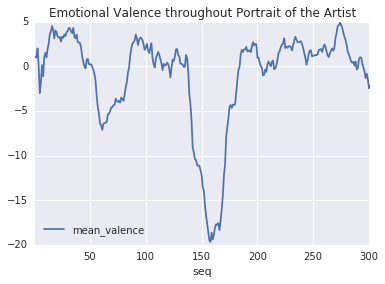

In [ ]:
perpage.plot(x='seq',y=['mean_valence'], title="Emotional Valence throughout Portrait of the Artist")

Jockers shows preference for Lowess smoothing for attaining a smooth 'shape' while avoiding issues with overcorrection. Let's compare.

Lowess smooths over a local fraction of the data, like a smarter moving average, so the parallel to the chart above would use a fraction of about `0.06` (i.e. a 20-page window). Jockers uses a 0.1 windows, and the charts by Benjamin Schmidt that he shares have a much larger smoothing window, so let's also try `0.1`, `0.2`, `0.3` and `0.4`.

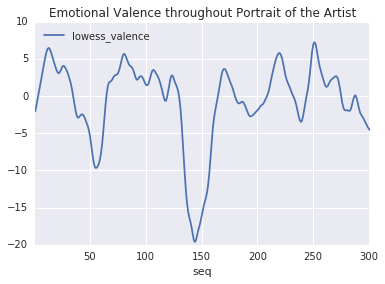

In [ ]:
lowess = sm.nonparametric.lowess
smoothed = lowess(exog=perpage['seq'], endog=perpage['sentiment_weight'],
                  frac=20.0/300)
perpage['lowess_valence'] = smoothed[:,1]
perpage.plot(x='seq',
             y='lowess_valence',
             title="Emotional Valence throughout Portrait of the Artist")

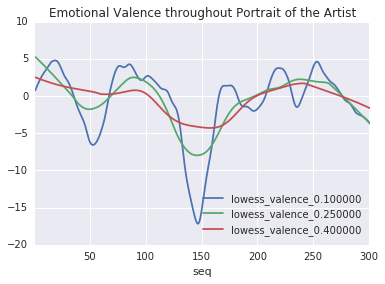

In [ ]:
fracs = [0.1, 0.25, 0.4]
for frac in fracs:
    smoothed = lowess(exog=perpage['seq'], endog=perpage['sentiment_weight'],
                      frac=frac)
    perpage['lowess_valence_%f' % frac] = smoothed[:,1]
perpage.plot(x='seq',
             y=['lowess_valence_%f' % frac for frac in fracs],
             title="Emotional Valence throughout Portrait of the Artist")

# References

Finn Årup Nielsen. May 2011. "A new ANEW: Evaluation of a word list for sentiment analysis in microblogs",
*Proceedings of the ESWC 2011 Workshop on 'Making Sense of Microposts':
Big things come in small packages 718 in CEUR Workshop Proceedings* : 93-98. 
http://arxiv.org/abs/1103.2903

Jockers, Matthew L. Feb 2015. "Revealing Sentiment and Plot Arcs with the Syuzhet Package". *Matthew L. Jockers.* Blog. http://www.matthewjockers.net/2015/02/02/syuzhet/.

Jockers, Matthew L. Apr 2015. Requiem for a low pass filter". *Matthew L. Jockers.* Blog. http://www.matthewjockers.net/2015/04/06/epilogue/.